In [1]:
!pip install transformers ecco datasets metrics transformers-interpret > /dev/null

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import ecco
from transformers_interpret import PairwiseSequenceClassificationExplainer
from datasets import load_dataset, load_metric
import warnings

warnings.filterwarnings('ignore')

# Transformers

# Encoder Only Models

## Layer Integrated Gradients

In [19]:
model_identifier = "yoshitomo-matsubara/bert-base-uncased-mrpc"  # model ID from huggingface

In [4]:
# load dataset

mrpc = load_dataset("glue", "mrpc")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
mrpc['validation'][0]

{'sentence1': "He said the foodservice pie business doesn 't fit the company 's long-term growth strategy .",
 'sentence2': '" The foodservice pie business does not fit our long-term growth strategy .',
 'label': 1,
 'idx': 9}

In [154]:
# tokenize examples
tokenizer = AutoTokenizer.from_pretrained(model_identifier)

def tokenizer_fn(examples):
    tokenized = tokenizer(examples['sentence1'], examples['sentence2'], truncation=True, max_length=128, padding='max_length')
    input_ids = tokenized['input_ids']
    tokenized['input'] = [tokenizer.convert_ids_to_tokens(x) for x in input_ids]
    return tokenized

mrpc_tokenized = mrpc.map(tokenizer_fn, batched=True)
mrpc_input = [x['input'] for x in mrpc_tokenized['validation']]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [7]:
mrpc_input[0]

['[CLS]',
 'he',
 'said',
 'the',
 'foods',
 '##er',
 '##vic',
 '##e',
 'pie',
 'business',
 'doesn',
 "'",
 't',
 'fit',
 'the',
 'company',
 "'",
 's',
 'long',
 '-',
 'term',
 'growth',
 'strategy',
 '.',
 '[SEP]',
 '"',
 'the',
 'foods',
 '##er',
 '##vic',
 '##e',
 'pie',
 'business',
 'does',
 'not',
 'fit',
 'our',
 'long',
 '-',
 'term',
 'growth',
 'strategy',
 '.',
 '[SEP]']

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_identifier, id2label={0: 'not equivalent', 1: 'equivalent'})

In [30]:
pairwise_explainer = PairwiseSequenceClassificationExplainer(model, tokenizer)

sample_id = 33
query = mrpc['validation']['sentence1'][sample_id]
context = mrpc['validation']['sentence2'][sample_id]
pairwise_attr = pairwise_explainer(query, context, class_name="equivalent")
pairwise_attr

[('[CLS]', 0.0),
 ('at', 0.002256995349345658),
 ('community', -0.24258172951039192),
 ('colleges', -0.07289701288713903),
 (',', 0.07535342802453096),
 ('tuition', -0.3130243995565343),
 ('will', 0.33207001568622796),
 ('jump', -0.6422741289107403),
 ('to', 0.13318481534314075),
 ('$', 0.029904325380982942),
 ('2', 0.025189137923712298),
 (',', -0.006500380263097067),
 ('800', -0.05628099950156019),
 ('from', 0.00510322486611351),
 ('$', 0.002365061352022029),
 ('2', -0.06287543872619068),
 (',', -0.0017820083820939807),
 ('500', 0.001892479640711604),
 ('.', -0.06298990544082968),
 ('[SEP]', 0.0),
 ('community', -0.1721238410761472),
 ('college', -0.018057225076535798),
 ('students', 0.037843978086682176),
 ('will', 0.18248906926181685),
 ('see', 0.17215637523716082),
 ('their', 0.11071299342822064),
 ('tuition', -0.3227152122604722),
 ('rise', 0.08272707937829359),
 ('by', 0.15167683061105833),
 ('$', 0.01750948023732602),
 ('300', 0.04113354169264424),
 ('to', 0.07057943403899553),

In [31]:
pairwise_explainer.predicted_class_index, pairwise_explainer.predicted_class_name

(array(0), 'not equivalent')

In [33]:
_ = pairwise_explainer.visualize(true_class=model.config.id2label[mrpc['validation']['label'][sample_id]])

In [34]:
pairwise_explainer = PairwiseSequenceClassificationExplainer(model, tokenizer)

sample_id = 33
query = mrpc['validation']['sentence1'][sample_id]
context = mrpc['validation']['sentence2'][sample_id]
pairwise_attr = pairwise_explainer(query, context, index=0)
_ = pairwise_explainer.visualize(true_class=model.config.id2label[mrpc['validation']['label'][sample_id]])

In [35]:
pairwise_explainer = PairwiseSequenceClassificationExplainer(model, tokenizer)

sample_id = 33
query = mrpc['validation']['sentence1'][sample_id]
context = mrpc['validation']['sentence2'][sample_id]
pairwise_attr = pairwise_explainer(query, context, index=1)
_ = pairwise_explainer.visualize(true_class=model.config.id2label[mrpc['validation']['label'][sample_id]])

## Similarity

In [160]:
model = AutoModelForSequenceClassification.from_pretrained(model_identifier, id2label={0: 'not equivalent', 1: 'equivalent'}, output_hidden_states=True)
model = model.eval().cuda()

In [161]:
mrpc_subset = mrpc_tokenized['validation'][:100]
mrpc_subset = {key: torch.tensor(mrpc_subset[key]).cuda() for key in ['input_ids', 'attention_mask', 'token_type_ids']}

In [162]:
outputs = model(**mrpc_subset)

In [166]:
outputs.hidden_states.__len__()

13

In [167]:
outputs.hidden_states[0].shape

torch.Size([100, 128, 768])

In [169]:
hidden_states = {}

for i, layer in enumerate(outputs.hidden_states):
    mask = mrpc_subset['attention_mask'].view(-1)
    hs = layer.view(-1, 768)
    active_tokens = hs[mask].detach().cpu().numpy()
    hidden_states[i] = active_tokens

100%|██████████| 13/13 [13:16<00:00, 61.26s/it]


<Axes: xlabel='j', ylabel='i'>

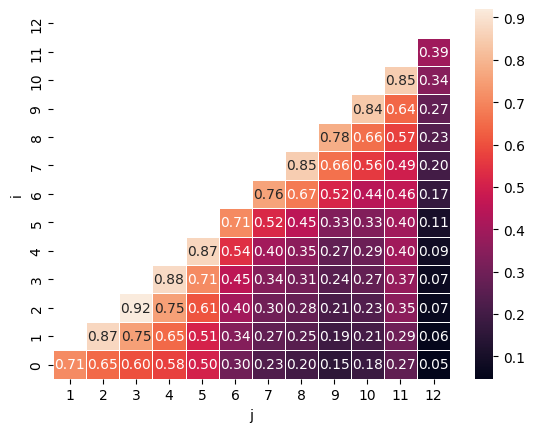

In [175]:
from ecco import analysis
import tqdm
import seaborn as sns
import pandas as pd
import numpy as np


similarity_scores = {"score": [], "i": [], "j": []}
for i in tqdm.trange(len(hidden_states)):
    for j in range(len(hidden_states)):
        if i < j:
            similarity_scores["score"].append(analysis.cka(hidden_states[i], hidden_states[j]))
            similarity_scores["i"].append(i)
            similarity_scores["j"].append(j)


heat_data = pd.DataFrame(data=similarity_scores).pivot("i", "j", "score").reindex(index=np.arange(12, -1, -1))
sns.heatmap(data=heat_data, annot=True, fmt=".2f", linewidth=.5)

# Generative Models

In [114]:
lm = ecco.from_pretrained('distilgpt2', activations=True)

In [41]:
text = " it was a matter of"

# Generate one token
output_1 = lm.generate(text, generate=1, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [49]:
output_1 = lm.generate(text, generate=10, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
output_1.layer_predictions(position=5, layer=5, topk=10)

<IPython.core.display.Javascript object>

In [44]:
output_1.layer_predictions(position=6, layer=5, topk=10)

<IPython.core.display.Javascript object>

In [45]:
output_1.layer_predictions(position=7, layer=5, topk=10)

<IPython.core.display.Javascript object>

In [47]:
lm.tokenizer(" time attitude money")['input_ids']

[640, 9408, 1637]

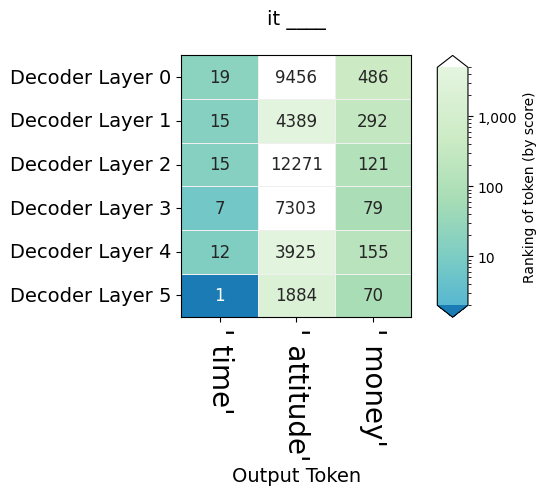

In [54]:
output_1.rankings_watch(watch=lm.tokenizer(" time attitude money")['input_ids'], position=5)

In [102]:
text = " Budapest is located in the country of"

# Generate one token
output_2 = lm.generate(text, generate=3, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
output_2.layer_predictions(position=7, layer=5)

<IPython.core.display.Javascript object>

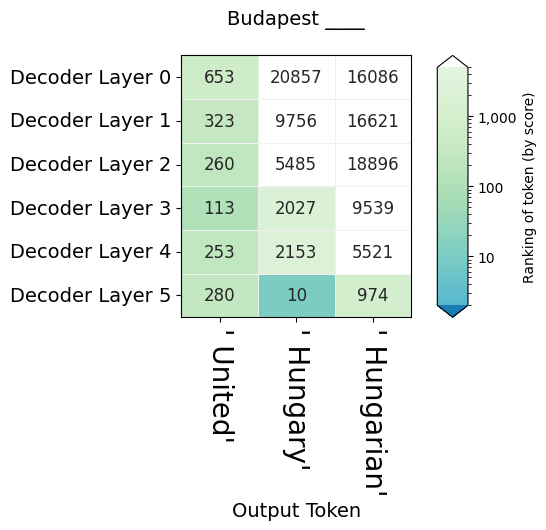

In [69]:
output_2.rankings_watch(watch=lm.tokenizer(" United Hungary Hungarian")['input_ids'], position=7)

In [70]:
output_2.layer_predictions(position=7, layer=5, topk=10)

<IPython.core.display.Javascript object>

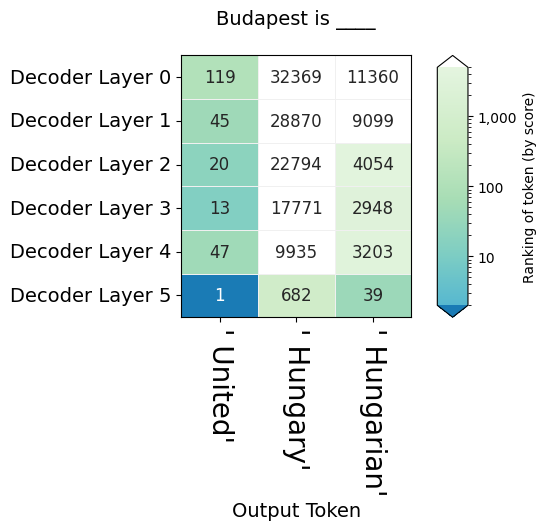

In [73]:
output_2.rankings_watch(watch=lm.tokenizer(" United Hungary Hungarian")['input_ids'], position=8)

In [71]:
output_2.layer_predictions(position=8, layer=5, topk=10)

<IPython.core.display.Javascript object>

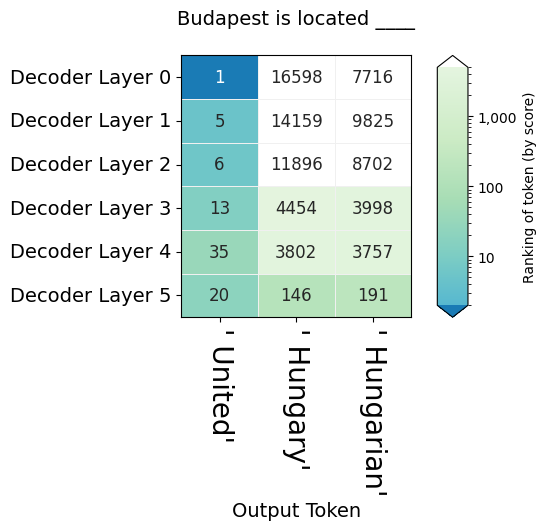

In [74]:
output_2.rankings_watch(watch=lm.tokenizer(" United Hungary Hungarian")['input_ids'], position=9)

In [72]:
output_2.layer_predictions(position=9, layer=5, topk=10)

<IPython.core.display.Javascript object>

In [129]:
text= "The countries of the European Union are:\n1. Austria\n2. Belgium\n3. Bulgaria\n4."

output_3 = lm.generate(text, generate=20, do_sample=True)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
text= "The countries and their capitals are:\n1. Austria - Vienna\n2. Germany - Berlin\n3. France - Paris\n4. Hungary - "

output__ = lm.generate(text, generate=20, do_sample=True)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

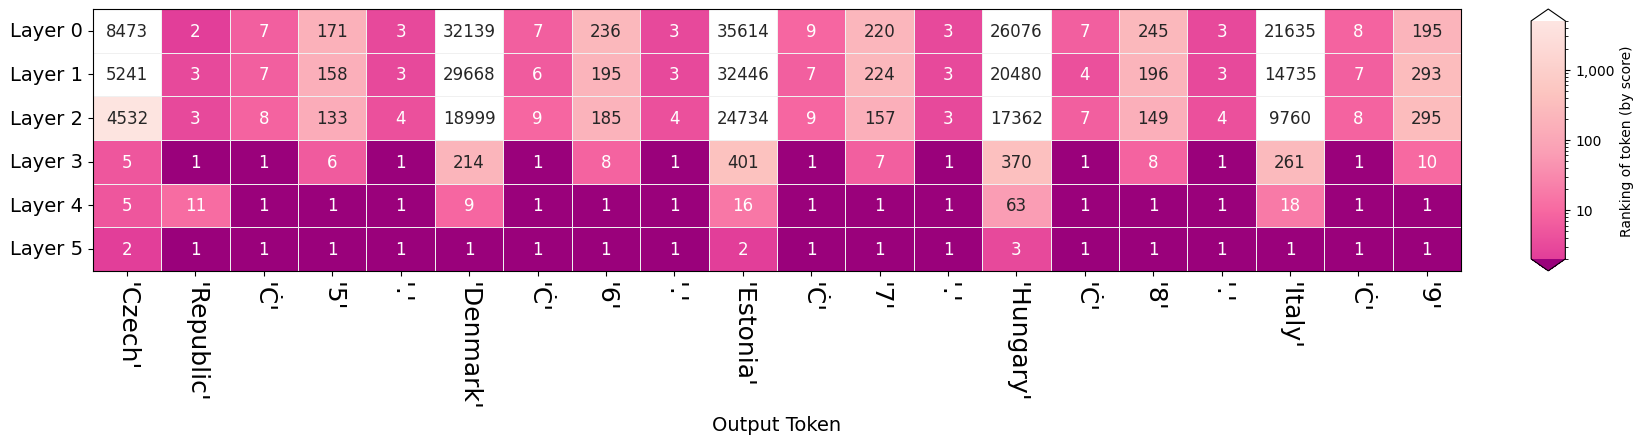

In [130]:
output_3.rankings()

In [131]:
nmf = output_3.run_nmf(n_components=6)
nmf

In [132]:
nmf.explore()

<IPython.core.display.Javascript object>